<a href="https://colab.research.google.com/github/Technology-for-the-Poorest-Billion/2025-Majicom-WaterCooling-passive/blob/main/GM2MajicomPassive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run to install libraries and initialise

In [11]:
!pip install CoolProp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI

Creates a set of classes to define various input parameters of interest: Air transport property, tank / kiosk geometry and fan behaviour

In [12]:
class AP: # Air Property
  def __init__(self,T,R, P = 101325):
    self.T = T # Temperature
    self.R = R # Relative Humidity
    self.P = P # Pressure

  def density(self):
    Vha = HAPropsSI('Vha', 'T', self.T, 'P', self.P, 'R', self.R)
    return 1/Vha

  def dynamicViscosity(self):
    return HAPropsSI('mu', 'T', self.T, 'P', self.P, 'R', self.R)

  def kinematicViscosity(self):
    return self.dynamicViscosity()/self.density()

  def thermalConductivity(self):
    return HAPropsSI('k', 'T', self.T, 'P', self.P, 'R', self.R)

  def diffusionCoefficient(self):
    D0 = 2.5 * (10**-5)
    T0 = 273.15
    D = D0*((self.T/T0)**1.75)  #CHECK THIS

    return D


class fanSpec: # fan properties
  def __init__(self,P, CFM):
    self.P = P # Power Consumption
    self.CFM = CFM # Mass flow rate (Cubic Feet per minute)


class tankGeo:
  def __init__(self,Router,Rinner,tankHeight,t, k):
    self.Router = Router # Kiosk Shell Radius
    self.Rinner = Rinner # Tank Radius
    self.tankHeight = tankHeight
    self.t = t # Wall thickness
    self.k = k # Thermal Conductivity of wall material

  def areaFlow(self):
    return np.pi*(self.Router**2) - np.pi*(self.Rinner**2)

  def volumeTank(self):
    return np.pi*(self.Rinner**2)*self.tankHeight

  def areaFlow(self):
    return np.pi*(self.Router**2) - np.pi*(self.Rinner**2)

  def areaTank(self):
    return np.pi*(self.Rinner**2)*self.tankHeight

class mat: # material

  def __init__(self,k,t,msat,density,porosity):
    self.k = k # Thermal Conductivity when dry
    self.t = t # Thickness
    self.msat = msat # Mass of water at maximum saturation per unit area of material
    self.density = density # Density of material (dry)
    self.porosity = porosity # Porosity of material (fraction of the total volume that is empty pores)










In [13]:
def velocityAir(tank: tankGeo ,fan: fanSpec):


  A = tank.areaFlow()
  Q = fan.CFM*0.00047194745                           # Unit conversion between Cubic Feet per Minute and m^3/s
  v = Q/A
  return v

def hm(tank: tankGeo, fan:fanSpec, air:AP):               # Defining the mass transfer coefficient for water into humid air

  L = tank.tankHeight

  v = velocityAir(tank,fan)
  Sc = air.kinematicViscosity()/air.diffusionCoefficient() # Schmidt Number
  Re = (v*L)/air.kinematicViscosity()                      # Reynold's Number with tank height as characteristic length

  Sh = 0.664*(Re**0.5)*(Sc**(1/3))                     # Sherwood Number

  return Sh*air.diffusionCoefficient()/L



def evaporationEnergy(tank: tankGeo, fan:fanSpec, material: mat, air: AP, S, Tf ): # New Variable S is the mass saturation = mass of water / maximum mass of water

  massCoeff = hm(tank,fan,air)

  A = tank.areaTank()
  densityWater = 1000 # kgm^3
  VTotal = tank.areaTank()*material.t
  VWater = S*material.msat/densityWater # Total volume of water added
  VPore = material.porosity*VTotal # Volume of pores
  VMaterial = VTotal - VPore

  kWater = 0.6 #estimate for thermal conductivity of water
  hAir = 10    # convective heat loss coefficient for air (may need to change)
  hfg = 2260e3 # Latent heat of evaporation (IS GIVING WEIRD ANSWERS)




  ## Handling 3 Phase mixture conductivity

  if VPore > VWater: # Not all pores in the fibre are occupied so there is still some air remaining

    VAir = VPore - VWater
    kTotal = (material.k*VMaterial + kWater*VWater + air.thermalConductivity()*VAir)/VTotal

  else: # The pores in the fibre are fully occupied with water and all air is displaced. Additional water can be absorbed by swelling

    kTotal = (material.k*VMaterial + kWater*VWater)/VTotal


  ## Defining the thermal resistances based on thermal conductivity


  Raf = 1/(hAir*A) #Thermal resistance from air to fabric
  Rfw = np.log((tank.Rinner + material.t) / tank.Rinner)/(2*np.pi*tank.tankHeight*kTotal) + np.log((tank.Rinner) / (tank.Rinner - tank.t) )/(2*np.pi*tank.tankHeight*tank.k) #Thermal resistance from fabric to water. Currently to surface of water
  Rawc = tank.t/(tank.k*2*np.pi*(tank.Rinner**2))
  Rawe = 0 # emissive resistance (0 is just a filler for now)
  Raw = Rawc # Likely temporary probably better to handle any radiative input as a current source into the water


  ## EValuating energy balance

  Tw = (Rfw * air.T + Raw * Tf)/(Raw + Rfw)
  Pv =  HAPropsSI('P_w', 'T', Tf, 'P', air.P, 'R', 1)
  Ps = HAPropsSI('P_w', 'T', air.T, 'P', air.P, 'R', air.R)
  mdot = S*massCoeff*A*(Pv - Ps)


  q_evap = mdot*hfg

  qaf = (air.T - Tf)/Raf
  qwf = (Tw - Tf)/Rfw

  e = qaf + qwf - q_evap # error

  return [Tw,e,mdot]


def waterTemperature(tank: tankGeo, fan:fanSpec, material: mat, air: AP, S):

  tol = 1e-3
  delta = 0.1
  Tf = air.T
  maxRunTime = 100

  for i in range (maxRunTime):


    e0 = evaporationEnergy(tank,fan,material,air,S,Tf)[1]
    e1 = evaporationEnergy(tank,fan,material,air,S,Tf + delta)[1]
    de = (e1 - e0)/delta
    Tf2 = Tf - e0/de


    if abs(e0) < tol:
      break
    else:
      Tf = Tf2

  Tw = evaporationEnergy(tank,fan,material,air,S,Tf)[0]

  return [Tw,Tf]



























Attempting to run functions with an initial starting point

In [14]:
airTest = AP(300, 0.2)
tankTest = tankGeo(1, 0.5, 0.5, 0.005, 0.5) # Guessing parameters at the right order of magnitude
materialTest = mat(0.9, 0.001, 1000,1000, 0.1)
fanTest = fanSpec(50,1000)

evaporationEnergy(tankTest,fanTest,materialTest,airTest,1,300)


print(300 - waterTemperature(tankTest,fanTest,materialTest,airTest,0.9)[0])





12.368573612179603


Temperatature and Humidity Variation:

One question majicom had was whether cool humid air would be a more effective cooling medium than warmer dry air. In order to answer this question water temperature has been calculated over a broad range of conditions and plotted on a heat map. This visualises the tradeoff between temperature and humidity. Diagonal bands show lines of constant cooling under varying conditions

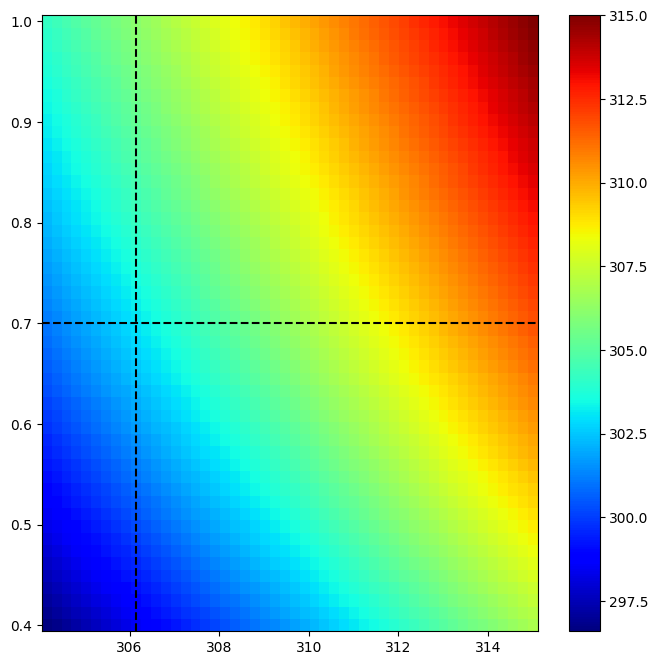

In [15]:
tempAvg = 273.15 + 33
tank = tankGeo(1, 0.5, 0.5, 0.005, 0.5)
material = mat(0.9, 0.001, 1000,1000, 0.5)
fan = fanSpec(50,1000)

Trange = np.linspace(tempAvg-2,315,50)
Rrange = np.linspace(0.4,1,50)
TwMatrix = np.zeros((len(Rrange), len(Trange)))
S = 0.5

for i, R in enumerate(Rrange):
  for j, T in enumerate(Trange):
    air = AP(T,R)
    TwMatrix[i,j] = waterTemperature(tank,fan,material,air,S)[0]


plt.figure(figsize=(8,8))
X,Y = np.meshgrid(Trange,Rrange)
c = plt.pcolormesh(X,Y,TwMatrix, cmap='jet')
plt.colorbar(c)



plt.axvline(x = tempAvg, color = 'black', linestyle = '--')
plt.axhline(y = 0.7, color = 'black', linestyle = '--')



plt.show()

Material Database:

The next step is to produce a database of material properties that we are considering. This will contain a range of material properties for different materials that are of interest

Fan Models:

The model of fan will have a notable effect on the rate of cooling. It will affect air speed and power consumption. Below are a range of fans that are being considered for this application.

In [15]:
fanModel = fan() #PV123812DSPF 01

Validation against experiment:

An important validation step is comparing the data produced by this model to real world data taken in the lab. Below is a comparison of the experimental data with the simulated data taken under equivalent conditions to those in the lab

In [15]:
tankModel = tankGeo()
tankReal = tankGeo ()

Cooling Rates:

So far all modelling has worked under the assumption that the saturation of the material remains constant. This is a reasonable assumption that stems from the intent to spray, mist or soak the material through some means. It is, as a result, important to understand how long the material would take to dry without any misting. This will help the team at majicom determine how often the material needs to be resoaked

In [36]:
def coolingTime(tank: tankGeo, fan:fanSpec, material: mat, air: AP, Sinit, Sfinal):

  A = tank.areaTank()
  mWaterSat = material.msat*A

  massCoeff = hm(tank,fan,air)


  # Initialise
  S = Sinit
  minit = Sinit*mWaterSat
  mfinal = Sfinal*mWaterSat
  mWater = minit
  dt = 600 #Time interval in seconds
  time = 0

  # Drying loop

  while mWater > mfinal:
    Tf = waterTemperature(tank,fan,material,air,S)[1]
    mdotEvap = evaporationEnergy(tank,fan,material,air,S,Tf)[2]
    dm = mdotEvap*dt
    mWater -= dm



    time += dt
    if mWater < mfinal:

      mWater = mfinal


  return time/60











In [37]:
print(coolingTime(tankTest,fanTest,materialTest,airTest,1,0))

7250.0


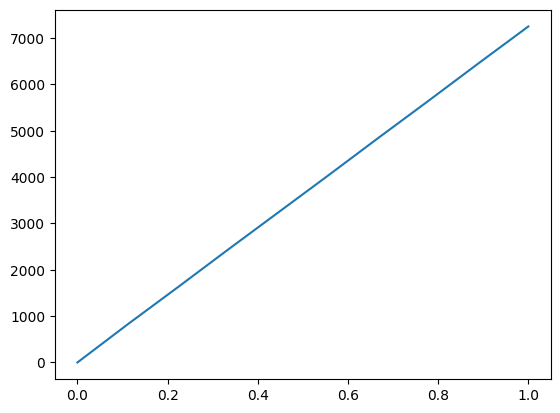

In [40]:

S = np.linspace(0,1,10)
time = np.zeros(len(S))
for i, s in enumerate(S):
  time[i] = coolingTime(tankTest,fanTest,materialTest,airTest,s,0)


plt.plot(S,time)
plt.show()

Currently the numbers from this seem to large. In order to test this, I will compare these results with the experimental work done. Experimental data will provide: saturated mass and mass loss within a specific period of time. For the air conditions in lab and the geometry of the apparatus, I can estimate and compare cooling time to reach a specific saturation ratio

Axial temperature gradients. Does